# Primeiros passos com Convolutional Neural Networks (CNNs)

Agora que já aprendemos o que é uma rede neural e como ela funciona, vamos conhecer uma técnica nova de machine learning, que pertence ao grupo das técnicas de *Deep Learning*. O nosso objetivo dessa vez será classificar rostos de pessoas!

Vamos começar importando todos os módulos que iremos utilizar ao longo da nossa implementação.

In [69]:
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
from sklearn.metrics import confusion_matrix
%matplotlib notebook
import matplotlib.pyplot as plt

## Funções utilitárias

Para  visualizar alguns dos nossos resultados, precisaremos utilizar as funções utilitárias abaixo.

In [70]:
def plot_images(images, img_shape, target_class, predicted_class = None):

    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i].reshape(img_shape), cmap='gray')

            if predicted_class is None:
                xlabel = "True: {0}".format(target_class[i])
            else:
                xlabel = "True: {0}, Pred: {1}".format(target_class[i], predicted_class[i])

        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [71]:
def plot_example_errors(predicted_class, img_shape, correct, data_test_images, data_test_classes):

    lim = 9

    incorrect = (correct == False)

    if len(incorrect) < lim:
        lim = len(incorrect) - 1
    
    images = data_test_images[incorrect]
    
    predicted_class = predicted_class[incorrect]

    target_class = data_test_classes[incorrect]
    
    plot_images(images = images[0:lim], img_shape = img_shape,  target_class = target_class[0:lim], predicted_class = predicted_class[0:lim])

In [73]:
def plot_confusion_matrix(predicted_class, data_test_classes, num_classes):

    target_class = data_test_classes

    cm = confusion_matrix(y_true = target_class, y_pred = predicted_class)

    plt.matshow(cm)

    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()

In [74]:
def print_test_accuracy(data_test_images, data_test_classes, session, test_batch_size,img_shape,
                    num_classes, show_example_errors = True, show_confusion_matrix = True):

    num_test = len(data_test_images)
    predicted_class = np.zeros(shape = num_test, dtype = np.int)

    i = 0

    while i < num_test:

        j = min(i + test_batch_size, num_test)
        images = data_test_images[i:j, :]
        labels = data_test_classes[i:j, :]
        feed_dict_test = {input_images: data_test_images, image_labels: data_test_classes, keep_prob: 0.2}
        predicted_class[i:j] = session.run(predictions, feed_dict = feed_dict_test)

        i = j

    one_hot_class = np.asarray(data_test_classes)

    true_labels = []
    for label in one_hot_class:
        l = label.argmax()
        true_labels.append(l)

    target_class = np.array(true_labels)

    predicted_class = np.asarray(predicted_class)
   
    correct = (target_class == predicted_class)

    correct_sum = correct.sum()

    acc = float(correct_sum) / num_test

    msg = "Acurácia no dataset de treino: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    if show_example_errors:
        print("Classificações erradas:")
        plot_example_errors( predicted_class = predicted_class, img_shape = img_shape, 
                            correct = correct, data_test_images = data_test_images, data_test_classes = target_class)

    if show_confusion_matrix:
        print("Matrix de confusão:")
        plot_confusion_matrix(predicted_class = predicted_class, data_test_classes = target_class, num_classes = num_classes)

In [77]:
def get_images(filename, num_classes = 22, height = 80, width = 80):

    filename_queue = tf.train.string_input_producer([filename], num_epochs = None)
    record_reader = tf.TFRecordReader()
    key, full_example = record_reader.read(filename_queue)

    features = tf.parse_single_example(full_example, features = {
        'image/height':tf.FixedLenFeature([], tf.int64),
        'image/width': tf.FixedLenFeature([], tf.int64),
        'image/colorspace': tf.FixedLenFeature([], dtype = tf.string, default_value = ''),
        'image/channels': tf.FixedLenFeature([], tf.int64),
        'image/class/label': tf.FixedLenFeature([], tf.int64),
        'image/class/text': tf.FixedLenFeature([], dtype = tf.string, default_value = ''),
        'image/format': tf.FixedLenFeature([], dtype = tf.string, default_value = ''),
        'image/filename': tf.FixedLenFeature([], dtype = tf.string, default_value = ''),
        'image/encoded': tf.FixedLenFeature([], dtype = tf.string, default_value = '')
        }) 

    label = features['image/class/label']
    image_buffer = features['image/encoded']

    with tf.name_scope('decode_jpeg', [image_buffer], None):

        image = tf.image.decode_jpeg(image_buffer, channels = 1)
        image = tf.image.convert_image_dtype(image, dtype = tf.float32)


    images = tf.reshape(image, [height * width])
    labels = tf.stack(tf.one_hot(label - 1, num_classes))

    return images, labels

## Hora de definir o nosso grafo de fluxo de dados

Primeiramente, iremos trabalhar com uma CNN pequena para que possamos entender melhor os conceitos relacionados a essa nova técnica. 

Lembre-se que os scripts em TensorFlow devem sempre ser estruturados em duas partes principais, que são: **Grafos** e **Sessões**. Então, vamos começar construindo o grafo para o nosso novo modelo. 

In [78]:
image_size = 80
num_classes = 22
num_channels = 1
num_filters = 32
filter_size = 5
learning_rate = 0.001
fully_connected_size = 128

graph = tf.Graph()
    
# Define os componentes e as operações que serão realizadas no modelo
with graph.as_default():

    # Placeholders for input, output and dropout
    input_images = tf.placeholder(tf.float32, shape = [None, image_size * image_size], name = 'input')	
    image_labels = tf.placeholder(tf.float32, shape = [None, num_classes], name = 'labels')
    keep_prob = tf.placeholder(tf.float32)

    # Reshapes input and output data
    images_reshaped = tf.reshape(input_images, [-1, image_size, image_size, num_channels])
    target_classes = tf.argmax(image_labels, dimension = 1)

    # Creates a convolutional + max-pooling layer
    with tf.name_scope("conv-and-maxpool"):

        shape = [filter_size, filter_size, num_channels, num_filters]
        weights = tf.Variable(tf.truncated_normal(shape, stddev = 0.05), name = 'weights')
        bias = tf.Variable(tf.zeros(shape = [num_filters]), name = 'bias')

        conv = tf.nn.conv2d(input = images_reshaped, filter = weights, strides = [1, 1, 1, 1], padding = 'SAME', name = 'convolution')
        bias_added = tf.nn.bias_add(value = conv, bias = bias, name = 'add-bias')
        activated_layer = tf.nn.relu(bias_added, name = 'relu')

        pooled = tf.nn.max_pool(value = activated_layer, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME', name = 'maxpooling')

    # Creates a dropout layer
    with tf.name_scope("dropout"):
        drop_layer = tf.nn.dropout(pooled, keep_prob)

    # Crates a flatten layer
    with tf.name_scope("flat"):

        layer_shape = drop_layer.get_shape()

        num_features = np.array(layer_shape[1:4], dtype = int).prod()
        num_features = layer_shape[1:4].num_elements()

        flatten_layer = tf.reshape(drop_layer, [-1, num_features])

    # Creates a fully-connected layer
    with tf.name_scope("fully-connected"):

        fc_weights = tf.Variable(tf.truncated_normal([num_features, fully_connected_size], stddev = 0.05), name = 'weights')
        fc_bias = tf.Variable(tf.zeros(shape = [fully_connected_size]), name = 'bias') 

        layer = tf.matmul(flatten_layer, fc_weights) + fc_bias

        fully_connected_layer = tf.nn.relu(layer)

    # Outputs acores and predictions
    with tf.name_scope("output"):

        out_weights = tf.Variable(tf.truncated_normal([fully_connected_size, num_classes], stddev = 0.05), name = 'weights')
        out_bias = tf.Variable(tf.zeros(shape = [num_classes]), name = 'bias') 

        output_layer = tf.matmul(fully_connected_layer, out_weights) + out_bias

        scores = tf.nn.softmax(output_layer, name = 'scores')
        predictions = tf.argmax(scores, dimension = 1, name = 'predictions')

    # Calculates cross-entropy loss
    with tf.name_scope("loss"):

        losses = tf.nn.softmax_cross_entropy_with_logits(logits = output_layer, labels = image_labels)
        cost = tf.reduce_mean(losses)
        optmizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    # Accuracy
    with tf.name_scope("accuracy"):

        correct_predictions = tf.equal(predictions, target_classes)
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name = 'accuracy')

## Sessão

Como vimos anteriormente, para que seja possível treinar a nossa rede, precisamos definir uma sessão que execute o modelo acima. 

step 0, training accuracy 0.09375
Time usage: 0:00:46
Acurácia no dataset de treino: 72.7% (186 / 256)
Classificações erradas:


<IPython.core.display.Javascript object>


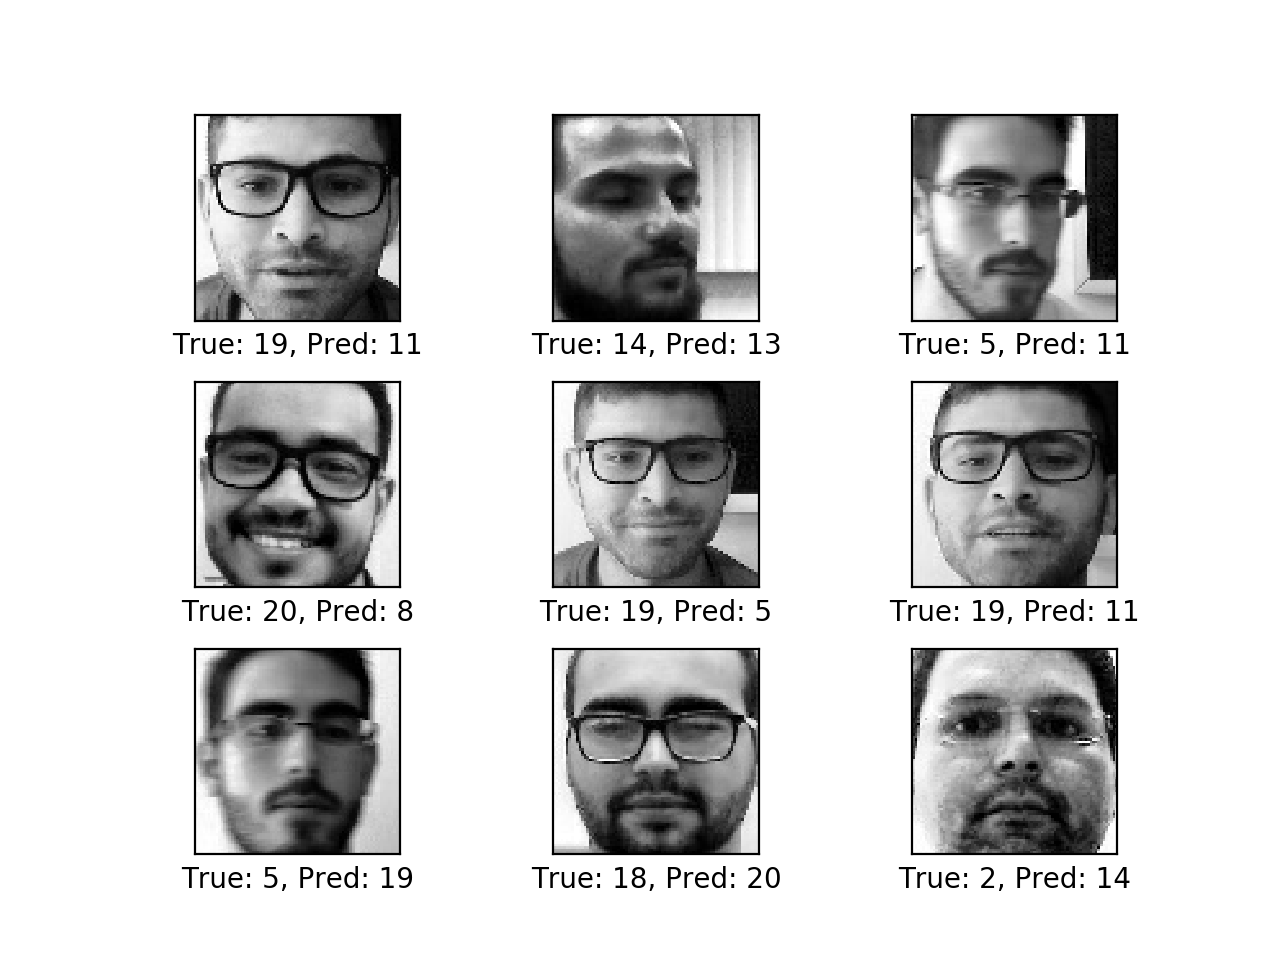

Matrix de confusão:


<IPython.core.display.Javascript object>


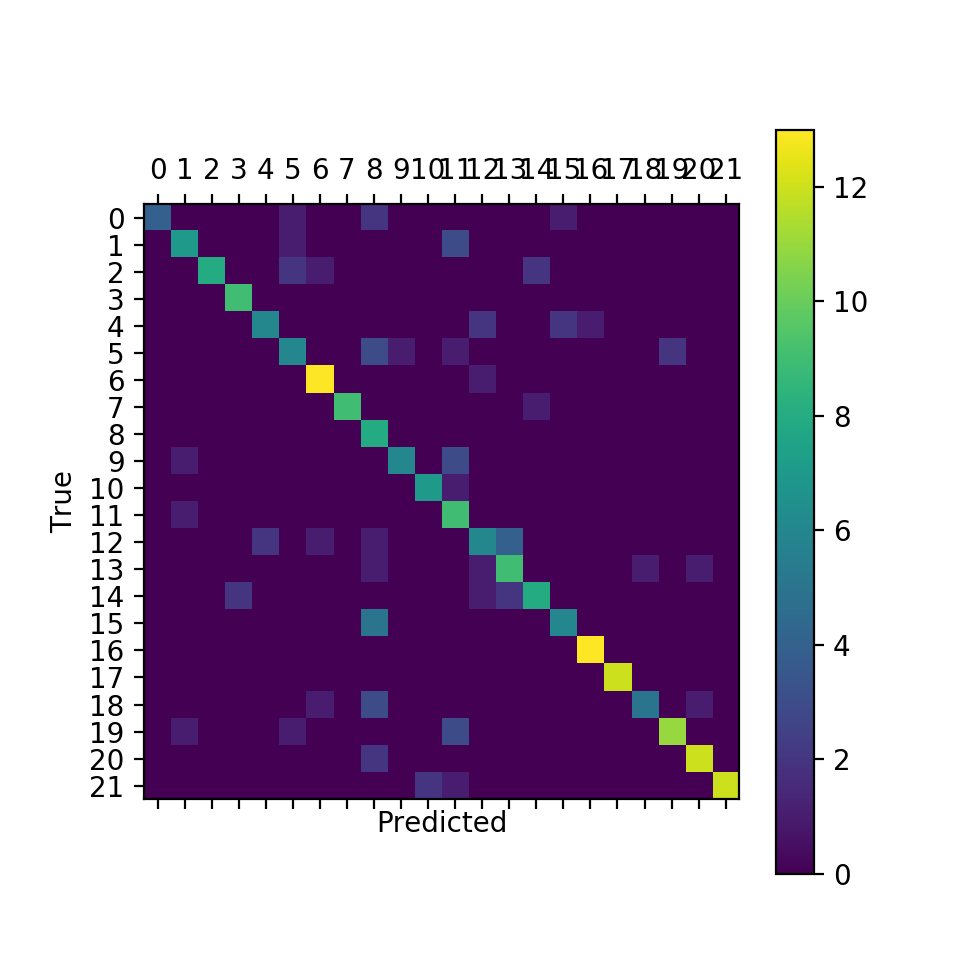

In [80]:
with tf.Session(graph = graph) as session:
    
    batch_size = 256
    training_steps = 20

    #Gets training images and their labels from a tfrecods file
    images, labels = get_images("dataset_faces/train/train-data")

    #Shuffles the given tensors and creates a batch(for training the model)
    image_batch, label_batch = tf.train.shuffle_batch(
        [images, labels], batch_size = batch_size,
        capacity = 3 * batch_size,
        min_after_dequeue = batch_size)

    # Gets testing images and their labels from a tfrecods file
    vimages, vlabels = get_images("dataset_faces/test/validation-data")

    # Shuffles the given tensors and creates a batch(for testing the model)
    vimage_batch, vlabel_batch = tf.train.shuffle_batch(
        [vimages, vlabels], batch_size = batch_size,
        capacity = 3 * batch_size,
        min_after_dequeue = batch_size)

    # Initializes all variables all variables in the session with the values you told them to hold
    tf.global_variables_initializer().run()
    
    # Saves all global variables(the model as a whole) in a file
    #saver = tf.train.Saver(tf.global_variables())
    
    # Coordinates the termination of a set of threads used for reading files
    coord = tf.train.Coordinator()
    
    # Holds a list of enqueue operations for a queue, each to be run in a thread
    threads = tf.train.start_queue_runners(sess = session, coord = coord)
    
    # Evaluates the batch tensors
    test_batch_x, test_batch_y = session.run([vimage_batch, vlabel_batch])
    
    # Returns time as a floating number expressed in seconds before the training process has started
    start_time = time.time()
    # Starts training the model
    
    for i in range(training_steps):
        
        # Evaluates the training batch tensors in order to have a different mini-batch at each training step
        batch_x, batch_y = session.run([image_batch, label_batch])
        
        # Creates a Python dictionary with placeholders as keys and the feed tensors as values
        feed_dict_train = {input_images: batch_x, image_labels: batch_y, keep_prob: 0.2}
        
        # Runs the model optimizer
        session.run(optmizer, feed_dict = feed_dict_train)
        if ((i%20) == 0):
            # Evaluates training accuracy at each step
            train_accuracy = session.run(accuracy, feed_dict = feed_dict_train)
            
            # Saves session model at each training step
            #saver.save(session, '/mymodel', global_step = i)
            
            # Prints training accuracy
            print("step %d, training accuracy %g" % (i, train_accuracy))

    # Returns time as a floating number expressed in seconds after once the training process has finished
    end_time = time.time()
    
    # Calculates how much time the training process has taken
    time_dif = end_time - start_time
    
    # Prints the time usage of the training process
    print("Time usage: " + str(timedelta(seconds = int(round(time_dif)))))
    # Prints test accuracy, confusion matrix and some misclassified examples if any afte the model has been trained
    print_test_accuracy(test_batch_x, test_batch_y,session, batch_size, (image_size, image_size), num_classes = num_classes)
    
    # Asks for all the threads to stop
    coord.request_stop()
    # Waits for all the threads to terminate
    coord.join(threads)


## Atividades! 

### Tensorboard
Tente utilizar o Tensorboard para visualizar o grafo desse modelo. Para isso, você vai precisar mudar algumas coisas nos scripts acima.

### Tente organizar melhor esse grafo
Aprendemos  que se não definirmos escopos para o nosso grafo a visualização do nosso modelo se tornará difícil.

### Tente acrescentar mais uma camada de convolução e max pooling na rede 
Quais foram os resultados?